In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

# Processing

In [4]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("List of input variables with example data")
print("PhysicalActivity, DietQuality, and  Sleep quality are all measured 1.0-10.0\n")
for col in X.columns:
    print(f"{col}: {X[col].iloc[0]}")



List of input variables with example data
PhysicalActivity, DietQuality, and  Sleep quality are all measured 1.0-10.0

Age: 73
EducationLevel: 2
BMI: 22.927749230993864
Smoking: 0
AlcoholConsumption: 13.29721772827684
PhysicalActivity: 6.327112473553353
DietQuality: 1.3472143059081076
SleepQuality: 9.025678665766115
HeadInjury: 0
Hypertension: 0
CholesterolTotal: 242.3668396963656
CholesterolLDL: 56.15089696091113
CholesterolHDL: 33.68256349839592
CholesterolTriglycerides: 162.18914307736603
MMSE: 21.46353236431666
FunctionalAssessment: 6.518876973217633
MemoryComplaints: 0
BehavioralProblems: 0
ADL: 1.7258834599441897
Confusion: 0
Disorientation: 0
PersonalityChanges: 0
DifficultyCompletingTasks: 1
Forgetfulness: 0
Gender_1: False
Ethnicity_1: False
Ethnicity_2: False
Ethnicity_3: False
FamilyHistoryAlzheimers_1: False


# Model Test Split


In [5]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Training

In [24]:
''' ----------- Logistic Model Training ----------- '''
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {accuracy* 100:.2f}%')

'''------------ Mythical Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=42)
forest.fit(X_train, y_train)
print("Number of trees in the Mythical Forest: " + str(len(forest.estimators_)))

'''----------------CatBoost Training--------'''
histGradient = HistGradientBoostingClassifier(max_iter=300)
histGradient.fit(X_train, y_train)

'''----------------XG Boost Training-------------------------'''
xgBoost = XGBClassifier(n_estimators=len(X_train), eval_metric='logloss')
xgBoost.fit(X_train, y_train)



Decision Tree Accuracy: 90.70%
Number of trees in the Mythical Forest: 1719


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# K-Fold Validation


In [7]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

'''---------- Forest K-Fold Model Training --------'''
scores = cross_val_score(forest, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validated forest accuracy:", scores.mean())

'''---------- CatBoost K-Fold Model Training --------'''
scores = cross_val_score(histGradient, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validated hist accuracy:", scores.mean())

'''---------- XG Boost K-Fold Model Training --------'''
scores = cross_val_score(xgBoost, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validated xgBoost accuracy:", scores.mean())

Cross-validated forest accuracy: 0.9502086502934144
Cross-validated hist accuracy: 0.9506715931319277
Cross-validated xgBoost accuracy: 0.9488111280156488


# Analysis

In [8]:
''' ----------- Evaluation ----------- '''
y_prob = model.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob[:5])
y_pred = model.predict(X_test)
print(f"y_pred: {y_pred[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


y_prob_forest = forest.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_forest = forest.predict(X_test)
print(f"y_pred: {y_pred_forest[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

y_prob_hist = histGradient.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_hist = histGradient.predict(X_test)
print(f"y_pred: {y_pred_hist[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_hist)
print(f"Accuracy: {accuracy * 100:.2f}%")

y_prob_xg = xgBoost.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_xg = xgBoost.predict(X_test)
print(f"y_pred: {y_pred_xg[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_xg)
print(f"Accuracy: {accuracy * 100:.2f}%")

Predicted probabilities for the first 5 examples:
 [[0.15301974 0.84698026]
 [0.72028516 0.27971484]
 [0.05358372 0.94641628]
 [0.46517875 0.53482125]
 [0.0013241  0.9986759 ]]
y_pred: [1 0 1 1 1]
y_test: [1 1 1 1 1]
Accuracy: 81.40%
Predicted probabilities for the first 5 examples:
 [[0.15415939 0.84584061]
 [0.85747528 0.14252472]
 [0.24898197 0.75101803]
 [0.52181501 0.47818499]
 [0.08551483 0.91448517]]
y_pred: [1 0 1 0 1]
y_test: [1 1 1 1 1]
Accuracy: 94.88%
Predicted probabilities for the first 5 examples:
 [[0.15415939 0.84584061]
 [0.85747528 0.14252472]
 [0.24898197 0.75101803]
 [0.52181501 0.47818499]
 [0.08551483 0.91448517]]
y_pred: [1 0 1 1 1]
y_test: [1 1 1 1 1]
Accuracy: 95.35%
Predicted probabilities for the first 5 examples:
 [[0.15415939 0.84584061]
 [0.85747528 0.14252472]
 [0.24898197 0.75101803]
 [0.52181501 0.47818499]
 [0.08551483 0.91448517]]
y_pred: [1 0 1 1 1]
y_test: [1 1 1 1 1]
Accuracy: 94.88%


# Visualization

### Logistic Regression Confusion Matrix

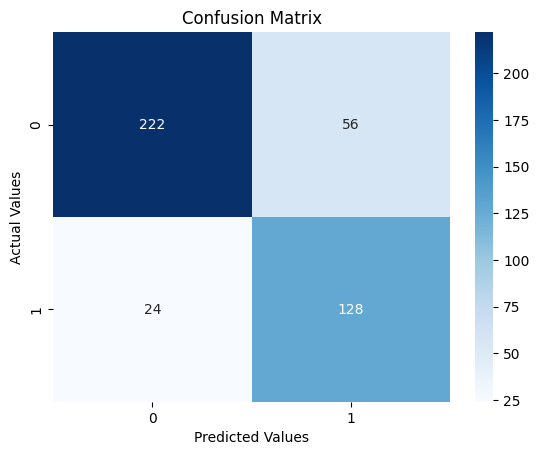

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

### Classification Report: Logistic Regression

In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430



### Mythical Forest Confusion Matrix

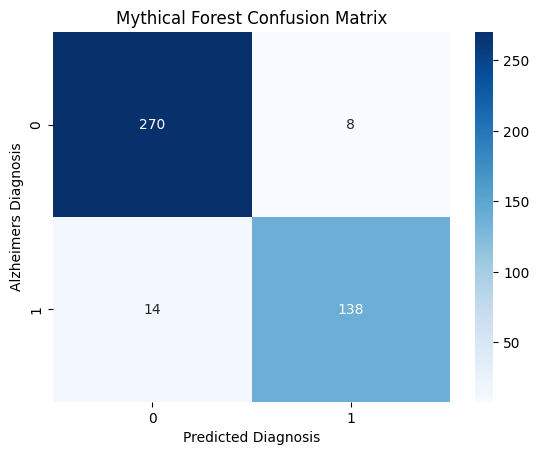

In [11]:
cm1 = confusion_matrix(y_test, y_pred_forest)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.title("Mythical Forest Confusion Matrix")
plt.ylabel("Alzheimers Diagnosis")
plt.xlabel("Predicted Diagnosis")
plt.show()

Hist Confusion Matrix

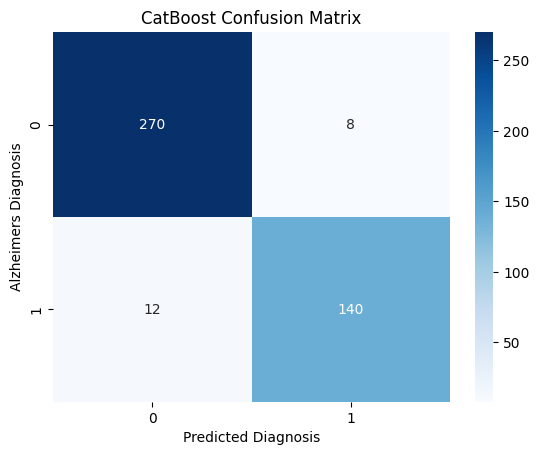

In [12]:
cm1 = confusion_matrix(y_test, y_pred_hist)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.ylabel("Alzheimers Diagnosis")
plt.xlabel("Predicted Diagnosis")
plt.show()

### Classification Report: Mythical Forest

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred_forest))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.95      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



### Logistic Regression ROC Curve

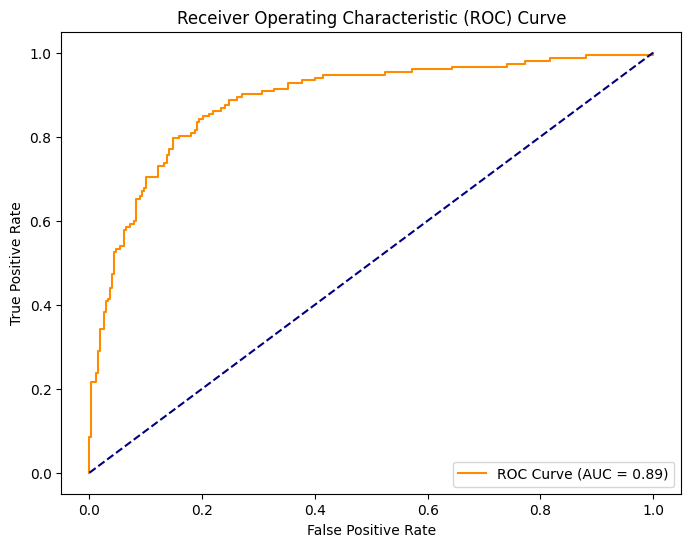

In [14]:
y_prob_class1 = y_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_class1)
roc_auc = roc_auc_score(y_test, y_prob_class1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Mythical Forest ROC Curve

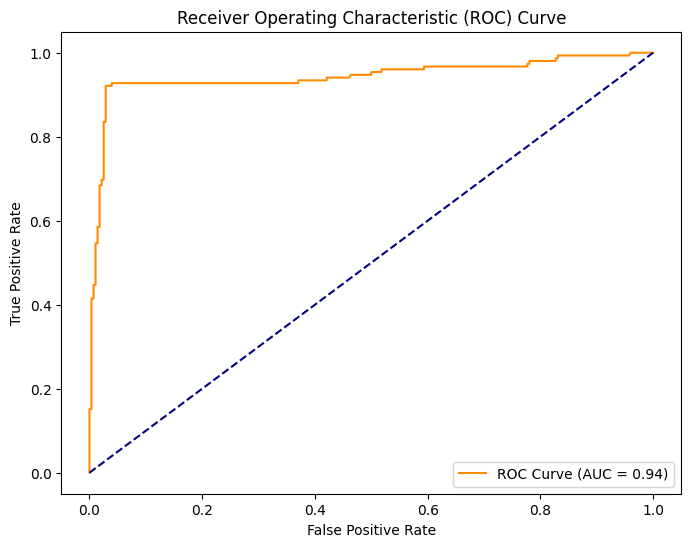

In [15]:
y_prob_forest = y_prob_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_forest)
roc_auc = roc_auc_score(y_test, y_prob_forest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Hist ROC Curve

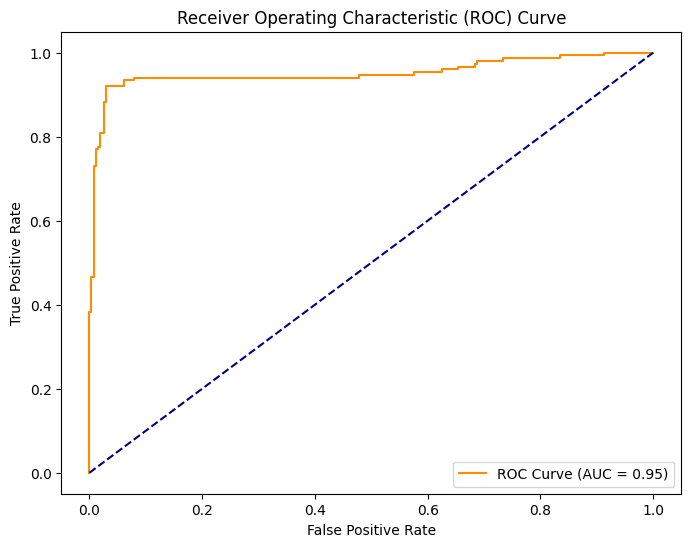

In [16]:
y_prob_hist = y_prob_hist[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_hist)
roc_auc = roc_auc_score(y_test, y_prob_hist)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:



"""
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
"""

'\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 10],\n    \'penalty\': [\'l1\', \'l2\'],\n    \'solver\': [\'liblinear\']\n}\ngrid = GridSearchCV(LogisticRegression(class_weight=\'balanced\', max_iter=1000), param_grid, cv=5, scoring=\'roc_auc\')\ngrid.fit(X_train, y_train)\nprint("Best Parameters:", grid.best_params_)\n'

### Plotting Risk as a function of Age

In [19]:
#creates a new dataframe with one singular patient, and iterates their age until age = 100
#def patientAgeDF:
